# Individual Project
# Formal modelling and statistical analysis of TOR

### Author: Leonidas Reppas
### Supervisor: Gethin Norman

#### Libraries:

In [9]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np

#### Relay statistics from the TOR network for 2019 (gathered from Tor metrics):
* Roughly 6000 relays
* 2500 guard-flagged
* 1000 exit-flagged
* 1500 guard&exit-flagged
* 2500 Non-flagged or stable/running but cannot acquire Guard and/or Exit flag
* Users: 2,000,000

In [2]:
# Network setup / Relay creation

# Have different global variables for differently flagged nodes
total_nodes = 0
guard_nodes = 0
exit_nodes = 0
guard_exit_nodes = 0
non_flagged_nodes = 0

class Relays():
    '''
    This class deals with the creation of the relay types
    '''
    
    def create_guard_nodes(self, number):
        global guard_nodes, total_nodes
        guard_nodes += number
        
    def create_exit_nodes(self, number):
        global exit_nodes, total_nodes
        exit_nodes += number
    
    def create_guard_exit_nodes(self, number):
        global guard_exit_nodes, total_nodes
        guard_exit_nodes += number
    
    def create_non_flagged_nodes(self, number):
        global non_flagged_nodes
        non_flagged_nodes += number
        
    def calculate_total_nodes(self):
        global guard_nodes, exit_nodes, guard_exit_nodes, non_flagged_nodes, total_nodes
        total_nodes = guard_nodes + exit_nodes + non_flagged_nodes
        
    def print_nodes(self):
        global guard_nodes, exit_nodes, guard_exit_nodes, non_flagged_nodes, total_nodes
        
        print("""
        Number of guard nodes: {}
        Number of exit nodes: {}
        Number of guard & exit nodes: {}
        Number of non-flagged nodes: {}\n
        Number of total nodes in the network: {}
        """. format(guard_nodes, exit_nodes, guard_exit_nodes, non_flagged_nodes, total_nodes))
            
# Testing
relay = Relays()
relay.create_guard_nodes(2500)
relay.create_exit_nodes(1000)
relay.create_guard_exit_nodes(1500)
relay.create_non_flagged_nodes(2500)
relay.calculate_total_nodes()
relay.print_nodes()


        Number of guard nodes: 2500
        Number of exit nodes: 1000
        Number of guard & exit nodes: 1500
        Number of non-flagged nodes: 2500

        Number of total nodes in the network: 6000
        


#### Path selection algorithm implemented:
 * Node selection based on weights, calculated by node bandwidth.
This was an improvement to the uniformly random path selection. Now a node with 10x higher bandwidth than another node,
has 10x as many circuits and probabilistically 10x as much of the traffic. 

#### Bandwidth weight computation according to the network scarcity conditions:
* G: total bandwidth for guard-flagged nodes = 150Gbit/s
* M: total bandwidth for non-flagged nodes = 50Gbit/s
* E: total bandwidth for exit-flagged nodes = 300Gbit/s
* D: total bandwidth for guard&exit-flagged nodes = 275Gbit/s
* T = G + M + E + D = 775Gbit/s

Network scarcity condition: E >= T/3 but G < T/3 (300>258 but 150<258)
So weight solution is(weight_scale=10,000):
* Wgg = weight_scale
* Wgd = (weight_scale*(D - 2*G + E + M)) / (3*D)
* Wmg = 0
* Wee = (weight_scale*(E + M)) / (2*E)
* Wme = weight_scale - Wee
* Wmd = (weight_scale - Wgd) / 2
* Wed = Wmd

In [3]:
# Defining bandwidth values as global variables (in Gbit/s)
G = 150
M = 50
E = 300
D = 275
T = G + M + E + D
weight_scale = 10000
w_gg = 0
w_gd = 0
w_mg = 0
w_md = 0 
w_me = 0
w_ee = 0
w_ed = 0

In [4]:
# Path Selection Algorithm 
class TorPath():
    '''
    This class deals with the bandwidth weight path 
    selection algorithm for the different user models defined
    '''
    
    def calculate_bandwidth_weights(self):
        # cast the results to an integer to simplify the values
        global w_gg, w_gd, w_mg, w_ee, w_me, w_md, w_ed
        w_gg = weight_scale
        w_gd = int((weight_scale*(D - 2*G + E + M)) / (3*D))
        w_mg = 0
        w_ee = int((weight_scale*(E + M)) / (2*E))
        w_me = int(weight_scale - w_ee)
        w_md = int((weight_scale - w_gd) / 2)
        w_ed = int(w_md)
        
    def print_bandwidth_weights(self):
        global w_gg, w_gd, w_mg, w_ee, w_me, w_md, w_ed
        print("""
        Weights for selecting a guard node:
            guard node: {}
            guard&exit node: {}
        Weights for selecting a middle node:
            guard node: {}
            exit node: {}
            guard&exit node: {}
        Weights for selecting an exit node:
            exit node: {}
            guard&exit: {}
        """.format(w_gg, w_gd, w_mg, w_me, w_md, w_ee, w_ed))
    
    def choose_range_guard(self):
        range_selector = random.randrange(1, 85)
        
        if range_selector == 1:
            range_choice = "very low"
        elif range_selector > 1 and range_selector <= 4:
            range_choice = "low"
        elif range_selector > 4 and range_selector <= 16:
            range_choice = "medium"
        elif range_selector > 16 and range_selector <= 39:
            range_choice = "high"
        elif range_selector > 39 and range_selector <= 85:
            range_choice = "very high"
        else:
            print("Error selecting range for guard node!")
            
        return range_choice
    
    def choose_range_guard_exit(self):
        range_selector = random.randrange(1, 75)
        
        if range_selector == 1:
            range_choice = "very low"
        elif range_selector > 1 and range_selector <= 4:
            range_choice = "low"
        elif range_selector > 4 and range_selector <= 16:
            range_choice = "medium"
        elif range_selector > 16 and range_selector <= 39:
            range_choice = "high"
        elif range_selector > 39 and range_selector <= 75:
            range_choice = "very high"
        else:
            print("Error selecting range for guard and exit node!")
            
        return range_choice        
    
    def choose_range_exit(self):
        range_selector = random.randrange(1, 92)
        
        if range_selector == 1:
            range_choice = "very low"
        elif range_selector > 1 and range_selector <= 5:
            range_choice = "low"
        elif range_selector > 5 and range_selector <= 21:
            range_choice = "medium"
        elif range_selector > 21 and range_selector <= 51:
            range_choice = "high"
        elif range_selector > 51 and range_selector <= 92:
            range_choice = "very high"
        else:
            print("Error selecting a range for the exit node!")
            
        return range_choice
                
    # define the adversary model
    def deploy_adversary(self, bandwidth, ratio, nodes):
        # if we have two adversary nodes, deploy one guard and one exit node
        if nodes == 2:
            if ratio == 1:
                return (int(bandwidth/2), int(bandwidth/2))
            elif ratio == 3:
                return (int(bandwidth*3/4), int(bandwidth/4))
        if nodes == 3:
            # when dealing with 3 adverserial nodes, only consider a symmetrical split of the total bandwidth
            return (int(bandwidth/3), int(bandwidth/3), int(bandwidth/3))

            
    def attack_exit(self, user_model, range_selector, adversary_exit):
        if user_model == "typical":
            user_model_var = 0.9
        elif user_model == "irc":
            user_model_var = 0.3
        elif user_model == "bittorrent":
            user_model_var = 0.2
        
        available_exit_nodes = exit_nodes * user_model_var
        
        if range_selector == "very high" and adversary_exit >= 24:
            compromise = random.randrange(1, int(available_exit_nodes*0.05))
            if compromise == 1:
                return True
        elif range_selector == "high" and adversary_exit <= 24 and adversary_exit >= 12:
            compromise = random.randrange(1, int(available_exit_nodes*0.25)) 
            if compromise == 1:
                return True
        elif range_selector == "medium" and adversary_exit <= 12 and adversary_exit >= 4.8:
            compromise = random.randrange(1, int(available_exit_nodes*0.5)) 
            if compromise == 1:
                return True
        elif range_selector == "low" and adversary_exit <= 4.8 and adversary_exit >= 1.2:
            compromise = random.randrange(1, int(available_exit_nodes*0.25)) 
            if compromise == 1:
                return True
        elif range_selector == "very low" and adversary_exit <= 1.2 and adversary_exit >= 0.3:
            compromise = random.randrange(1, int(available_exit_nodes*0.05)) 
            if compromise == 1:
                return True
        else:
            return False
    
    def attack_guard(self, range_selector, adversary_guard):
        if range_selector == "very high" and adversary_guard >= 18:
            compromise = random.randrange(1, 125) 
            if compromise == 1:
                return True
        elif range_selector == "high" and adversary_guard <= 18 and adversary_guard >= 6:
            compromise = random.randrange(1, 625) 
            if compromise == 1:
                return True
        elif range_selector == "medium" and adversary_guard <= 6 and adversary_guard >= 2.4:
            compromise = random.randrange(1, 1250) 
            if compromise == 1:
                return True
        elif range_selector == "low" and adversary_guard <= 2.4 and adversary_guard >= 0.6:
            compromise = random.randrange(1, 625) 
            if compromise == 1:
                return True
        elif range_selector == "very low" and adversary_guard <= 0.6 and adversary_guard >= 0.23:
            compromise = random.randrange(1, 125)
            if compromise == 1:
                return True
        else:
            return False

    
    def create_streams_typical(self, number, adversary_guard, adversary_exit):
        # path compromises
        partial_compr = 0
        complete_compr = 0
        
        for i in range(number):
            # reset the compromise flags
            exit_compr = False
            guard_compr = False
            
            # select an exit node
            selector = random.randrange(1, int(w_ee + w_ed))
            
            if selector <= w_ee:
                exit_choice = "exit"
                range_selector = self.choose_range_exit()
                
                # relay attack
                exit_compr = self.attack_exit("typical", range_selector, adversary_exit)
                                    
            else:
                exit_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable
                
            # select a middle node
            selector = random.randrange(1, int(w_me + w_md))
            
            if selector <= w_me:
                middle_choice = "exit"
                range_selector = self.choose_range_exit()
                
            else:
                middle_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()

            # select a guard node
            selector = random.randrange(1, int(w_gg + w_gd))
            
            if selector <= w_gg:
                guard_choice = "guard"
                range_selector = self.choose_range_guard()
                
                # relay attack
                guard_compr = self.attack_guard(range_selector, adversary_guard)
                
            else:
                guard_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable 
            
            
            if exit_compr and guard_compr:
                complete_compr += 1
            elif exit_compr or guard_compr:
                partial_compr += 1
            
        #print("""
        #Typical User Model:
        #Number of full compromises: {}
        #Number of partial compromises: {}
        #""".format(complete_compr, partial_compr))
        
        return (complete_compr, partial_compr)
    
    
    def create_streams_irc(self, number, adversary_guard, adversary_exit):
        # path compromises
        partial_compr = 0
        complete_compr = 0
        
        for i in range(number):
            # reset the compromise flags
            exit_compr = False
            guard_compr = False
            
            # select an exit node
            selector = random.randrange(1, int(w_ee + w_ed))
            
            if selector <= w_ee:
                exit_choice = "exit"
                range_selector = self.choose_range_exit()
                
                # relay attack
                exit_compr = self.attack_exit("irc", range_selector, adversary_exit)
                                    
            else:
                exit_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable
                
            # select a middle node
            selector = random.randrange(1, int(w_me + w_md))
            
            if selector <= w_me:
                middle_choice = "exit"
                range_selector = self.choose_range_exit()
                
            else:
                middle_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()

            # select a guard node
            selector = random.randrange(1, int(w_gg + w_gd))
            
            if selector <= w_gg:
                guard_choice = "guard"
                range_selector = self.choose_range_guard()
                
                # relay attack
                guard_compr = self.attack_guard(range_selector, adversary_guard)
                
            else:
                guard_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable 
            
            
            if exit_compr and guard_compr:
                complete_compr += 1
            elif exit_compr or guard_compr:
                partial_compr += 1
            
        #print("""
        #IRC User Model:
        #Number of full compromises: {}
        #Number of partial compromises: {}
        #""".format(complete_compr, partial_compr))
        
        return (complete_compr, partial_compr)
    
    
    def create_streams_bittorrent(self, number, adversary_guard, adversary_exit):
        # path compromises
        partial_compr = 0
        complete_compr = 0
        
        for i in range(number):
            # reset the compromise flags
            exit_compr = False
            guard_compr = False
            
            # select an exit node
            selector = random.randrange(1, int(w_ee + w_ed))
            
            if selector <= w_ee:
                exit_choice = "exit"
                range_selector = self.choose_range_exit()
                
                # relay attack
                exit_compr = self.attack_exit("bittorrent", range_selector, adversary_exit)
                                    
            else:
                exit_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable
                
            # select a middle node
            selector = random.randrange(1, int(w_me + w_md))
            
            if selector <= w_me:
                middle_choice = "exit"
                range_selector = self.choose_range_exit()
                
            else:
                middle_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()

            # select a guard node
            selector = random.randrange(1, int(w_gg + w_gd))
            
            if selector <= w_gg:
                guard_choice = "guard"
                range_selector = self.choose_range_guard()
                
                # relay attack
                guard_compr = self.attack_guard(range_selector, adversary_guard)
                
            else:
                guard_choice = "guard&exit"
                range_selector = self.choose_range_guard_exit()
                
                # relay attack not applicable 
            
            
            if exit_compr and guard_compr:
                complete_compr += 1
            elif exit_compr or guard_compr:
                partial_compr += 1
            
        #print("""
        #Bittorrent User Model:
        #Number of full compromises: {}
        #Number of partial compromises: {}
        #""".format(complete_compr, partial_compr))
        
        return (complete_compr, partial_compr)
            
            
# Testing 
torpath = TorPath()
torpath.calculate_bandwidth_weights()
torpath.print_bandwidth_weights()


        Weights for selecting a guard node:
            guard node: 10000
            guard&exit node: 3939
        Weights for selecting a middle node:
            guard node: 0
            exit node: 4167
            guard&exit node: 3030
        Weights for selecting an exit node:
            exit node: 5833
            guard&exit: 3030
        


In [25]:
# Graph production for relay attack experiments
# 1: Typical user model

# Two Adversary nodes deployed; combined 50MiB/s; both very high bandwidth
print("***Total bandwidth: 50; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(50, 1, 2)
typ_complete_compr1, typ_partial_compr1 = torpath.create_streams_typical(68432, adversary_guard, adversary_exit)     

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
typ_complete_compr2, typ_partial_compr2 = torpath.create_streams_typical(136864, adversary_guard, adversary_exit)

# Same simulation for 24 monoths
print("Simulated period of 24 months(104 weeks): ")
typ_complete_compr3, typ_partial_compr3 = torpath.create_streams_typical(273728, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 30 MiB/s; both high bandwidth
print("***Total bandwidth: 30; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(30, 1, 2)
typ_complete_compr4, typ_partial_compr4 = torpath.create_streams_typical(68432, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
typ_complete_compr5, typ_partial_compr5 = torpath.create_streams_typical(136864, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
typ_complete_compr6, typ_partial_compr6 = torpath.create_streams_typical(273728, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 12 MiB/s; both medium bandwidth
print("***Total bandwidth: 12; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(12, 1, 2)
typ_complete_compr7, typ_partial_compr7 = torpath.create_streams_typical(68432, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
typ_complete_compr8, typ_partial_compr8 = torpath.create_streams_typical(136864, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
typ_complete_compr9, typ_partial_compr9 = torpath.create_streams_typical(273728, adversary_guard, adversary_exit)

***Total bandwidth: 50; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 30; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 12; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 


In [48]:
# 2: IRC user model

# Two Adversary nodes deployed; combined 50MiB/s; both very high bandwidth
print("***Total bandwidth: 50; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(50, 1, 2)
irc_complete_compr1, irc_partial_compr1 = torpath.create_streams_irc(3510, adversary_guard, adversary_exit)     

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
irc_complete_compr2, irc_partial_compr2 = torpath.create_streams_irc(7020, adversary_guard, adversary_exit)

# Same simulation for 24 monoths
print("Simulated period of 24 months(104 weeks): ")
irc_complete_compr3, irc_partial_compr3 = torpath.create_streams_irc(14040, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 30 MiB/s; both high bandwidth
print("***Total bandwidth: 30; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(30, 1, 2)
irc_complete_compr4, irc_partial_compr4 = torpath.create_streams_irc(3510, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
irc_complete_compr5, irc_partial_compr5 = torpath.create_streams_irc(7020, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
irc_complete_compr6, irc_partial_compr6 = torpath.create_streams_irc(14040, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 12 MiB/s; both medium bandwidth
print("***Total bandwidth: 12; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(12, 1, 2)
irc_complete_compr7, irc_partial_compr7 = torpath.create_streams_irc(3510, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
irc_complete_compr8, irc_partial_compr8 = torpath.create_streams_irc(7020, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
irc_complete_compr9, irc_partial_compr9 = torpath.create_streams_irc(14040, adversary_guard, adversary_exit)

***Total bandwidth: 50; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 30; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 12; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 


In [27]:
# 3: BitTorrent user model

# Two Adversary nodes deployed; combined 50MiB/s; both very high bandwidth
print("***Total bandwidth: 50; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(50, 1, 2)
bit_complete_compr1, bit_partial_compr1 = torpath.create_streams_bittorrent(175968, adversary_guard, adversary_exit)     

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
bit_complete_compr2, bit_partial_compr2 = torpath.create_streams_bittorrent(351936, adversary_guard, adversary_exit)

# Same simulation for 24 monoths
print("Simulated period of 24 months(104 weeks): ")
bit_complete_compr3, bit_partial_compr3 = complete_compr3, partial_compr3 = torpath.create_streams_bittorrent(703872, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 30 MiB/s; both high bandwidth
print("***Total bandwidth: 30; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(30, 1, 2)
bit_complete_compr4, bit_partial_compr4 = torpath.create_streams_bittorrent(175968, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
bit_complete_compr5, bit_partial_compr5 = torpath.create_streams_bittorrent(351936, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
bit_complete_compr6, bit_partial_compr6 = torpath.create_streams_bittorrent(703872, adversary_guard, adversary_exit)


# Two adversary nodes deployed; combined 12 MiB/s; both medium bandwidth
print("***Total bandwidth: 12; 2 nodes deployed***")
print("Simulated period of 6 months(26 weeks): ")
adversary_guard, adversary_exit = torpath.deploy_adversary(12, 1, 2)
bit_complete_compr7, bit_partial_compr7 = torpath.create_streams_bittorrent(175968, adversary_guard, adversary_exit)

# Same simulation for 12 months
print("Simulated period of 12 months(52 weeks): ")
bit_complete_compr8, bit_partial_compr8 = torpath.create_streams_bittorrent(351936, adversary_guard, adversary_exit)

# Same simulation for 24 months
print("Simulated period of 24 months(104 weeks): ")
bit_complete_compr9, bit_partial_compr9 = torpath.create_streams_bittorrent(703872, adversary_guard, adversary_exit)

***Total bandwidth: 50; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 30; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 
***Total bandwidth: 12; 2 nodes deployed***
Simulated period of 6 months(26 weeks): 
Simulated period of 12 months(52 weeks): 
Simulated period of 24 months(104 weeks): 


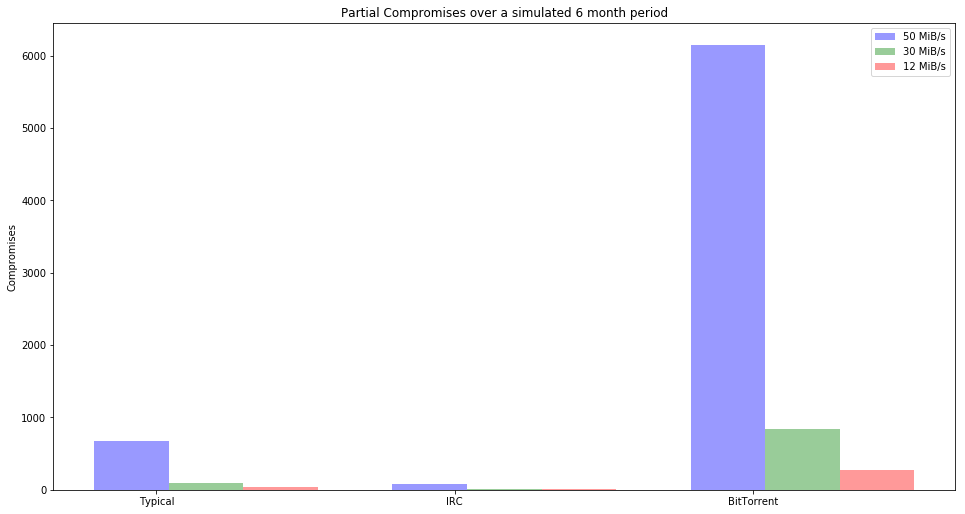

In [39]:
# Improved and more meaningful graph production
band50_values = (typ_partial_compr1, irc_partial_compr1, bit_partial_compr1)
band30_values = (typ_partial_compr4, irc_partial_compr4, bit_partial_compr4)
band12_values = (typ_partial_compr7, irc_partial_compr7, bit_partial_compr7)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Partial Compromises over a simulated 6 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
fig.set_size_inches(15, 8)
plt.show()

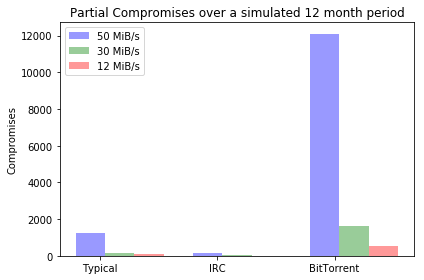

In [56]:
band50_values = (typ_partial_compr2, irc_partial_compr2, bit_partial_compr2)
band30_values = (typ_partial_compr5, irc_partial_compr5, bit_partial_compr5)
band12_values = (typ_partial_compr8, irc_partial_compr8, bit_partial_compr8)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Partial Compromises over a simulated 12 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
plt.show()

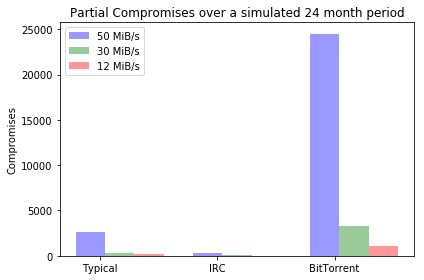

In [54]:
band50_values = (typ_partial_compr3, irc_partial_compr3, bit_partial_compr3)
band30_values = (typ_partial_compr6, irc_partial_compr6, bit_partial_compr6)
band12_values = (typ_partial_compr9, irc_partial_compr9, bit_partial_compr9)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Partial Compromises over a simulated 24 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
plt.show()

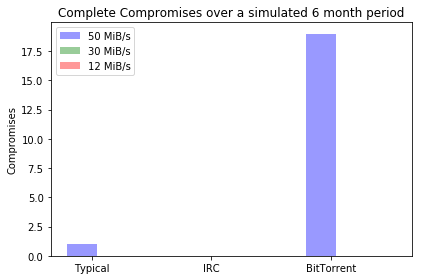

In [53]:
band50_values = (typ_complete_compr1, irc_complete_compr1, bit_complete_compr1)
band30_values = (typ_complete_compr4, irc_complete_compr4, bit_complete_compr4)
band12_values = (typ_complete_compr7, irc_complete_compr7, bit_complete_compr7)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Complete Compromises over a simulated 6 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
plt.show()

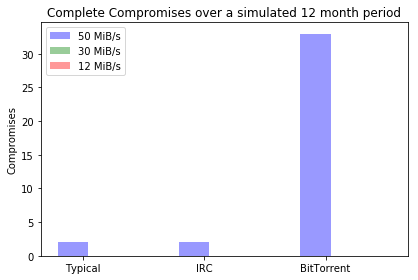

In [52]:
band50_values = (typ_complete_compr2, irc_complete_compr2, bit_complete_compr2)
band30_values = (typ_complete_compr5, irc_complete_compr5, bit_complete_compr5)
band12_values = (typ_complete_compr8, irc_complete_compr8, bit_complete_compr8)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Complete Compromises over a simulated 12 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
plt.show()

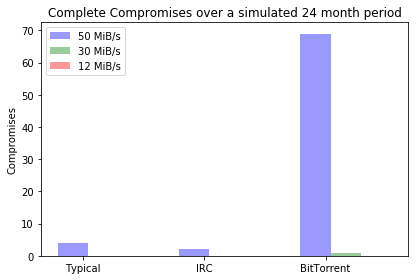

In [51]:
band50_values = (typ_complete_compr3, irc_complete_compr3, bit_complete_compr3)
band30_values = (typ_complete_compr6, irc_complete_compr6, bit_complete_compr6)
band12_values = (typ_complete_compr9, irc_complete_compr9, bit_complete_compr9)

fig, ax = plt.subplots()
n_groups = 3
bar_width = 0.25
index = np.arange(n_groups)
opacity = 0.4

rects1 = ax.bar(index, band50_values, bar_width,
                alpha=opacity, color='b',
                label='50 MiB/s')

rects2 = ax.bar(index + bar_width, band30_values, bar_width,
                alpha=opacity, color='g',
                label='30 MiB/s')

rects3 = ax.bar(index + (bar_width*2), band12_values, bar_width,
                alpha=opacity, color='r',
                label='12 MiB/s')

#ax.set_xlabel('Bandwidth(MiB/s)')
ax.set_ylabel('Compromises')
ax.set_title('Complete Compromises over a simulated 24 month period')
ax.set_xticks(index + bar_width / 3)
ax.set_xticklabels(('Typical', 'IRC', 'BitTorrent'))
ax.legend()

fig.tight_layout()
plt.show()

In [45]:
# Function to calculate the mean time to compromise for a 24 month period
def mean_time_compromise(value):
    if value > 0:
        return math.ceil(1/(value/180))
    else: return 0

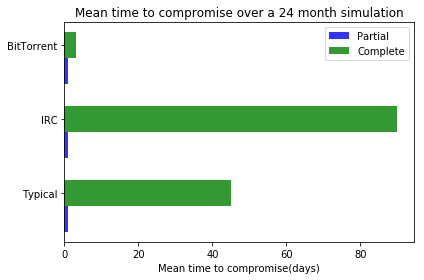

In [57]:
n_groups = 3
time_to_partial = (typ_partial_compr3, irc_partial_compr3, bit_partial_compr3)
time_to_complete = (typ_complete_compr3, irc_complete_compr3, bit_complete_compr3)
mean_partial = tuple(map(mean_time_compromise, time_to_partial))
mean_complete = tuple(map(mean_time_compromise, time_to_complete))
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.barh(index, mean_partial, bar_width,
alpha=opacity,
color='b',
label='Partial')
 
rects2 = plt.barh(index + bar_width, mean_complete, bar_width,
alpha=opacity,
color='g',
label='Complete')
 
plt.xlabel('Mean time to compromise(days)')
plt.title('Mean time to compromise over a 24 month simulation')
plt.yticks(index + bar_width, ('Typical', 'IRC', 'BitTorrent'))
plt.legend()
 
plt.tight_layout()
plt.show()